In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/ presentation/text_emotion.csv')
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [ ]:
df = df.drop(columns=['tweet_id','author'])

In [ ]:
print(df["sentiment"].unique())

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define a function to map emotions to categories
def map_emotion_to_category(emotion):
    if emotion in ['empty', 'sadness', 'worry', 'hate', 'boredom', 'anger']:
        return 'negative'
    elif emotion in ['enthusiasm', 'love', 'fun', 'happiness', 'relief']:
        return 'positive'
    else:
        return 'neutral'

# Assuming df is your DataFrame containing the 'sentiment' column
df['sentiment'] = df['sentiment'].apply(map_emotion_to_category)


# Checking value counts of the encoded sentiments
print(df['sentiment'].value_counts())


negative    16063
positive    13112
neutral     10825
Name: sentiment, dtype: int64


In [ ]:
print(df['sentiment'].unique())


['negative' 'positive' 'neutral']


In [ ]:
df['sentiment'] = LabelEncoder().fit_transform(df['sentiment'])

In [ ]:
df['sentiment'].value_counts()

0    16063
2    13112
1    10825
Name: sentiment, dtype: int64

In [ ]:
df.head()

,sentiment,content
0,0,@tiffanylue i know i was listenin to bad habi...
1,0,Layin n bed with a headache ughhhh...waitin o...
2,0,Funeral ceremony...gloomy friday...
3,2,wants to hang out with friends SOON!
4,1,@dannycastillo We want to trade with someone w...


In [ ]:
df['sentiment'].value_counts(normalize = True)


0    0.401575
2    0.327800
1    0.270625
Name: sentiment, dtype: float64

In [ ]:
train_content, temp_content, train_sentiment, temp_sentiment = train_test_split(df['content'], df['sentiment'],
                                                                                random_state=2018,
                                                                                test_size=0.5,
                                                                                stratify=df['sentiment'])

val_content, test_content, val_sentiment, test_sentiment = train_test_split(temp_content, temp_sentiment,
                                                                            random_state=2018,
                                                                            test_size=0.3,
                                                                            stratify=temp_sentiment)


In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

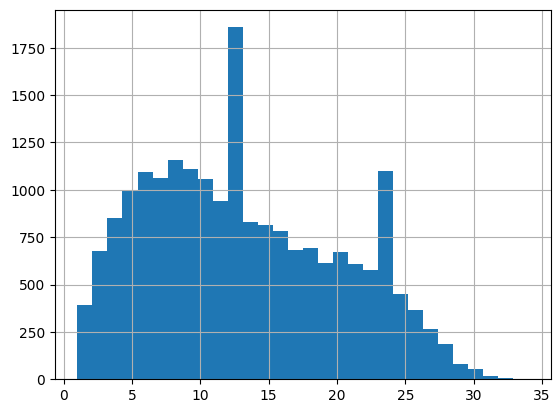

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_content]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_content.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_content.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_content.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_sentiment.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_sentiment.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_sentiment.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 50

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn
from transformers import BertModel

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.3)  # Increase dropout rate

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)
        self.relu1 = nn.ReLU()

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, 3)

        # softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

        # pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)
        x = self.relu1(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

# Load BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Instantiate the BERT architecture
model = BERT_Arch(bert_model)


In [ ]:

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_sentiment),
                                        y = test_sentiment
                                    )
print("Class Weights:",class_weights)

Class Weights: [0.83022001 1.23152709 1.01677682]


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

In [ ]:
# function to train the model
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

      # predictions are in the form of (no. of batches, size of batch, no. of classes).
      # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

In [ ]:
import time

def format_time(seconds):
    """Converts elapsed time in seconds to a hh:mm:ss format."""
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours), int(minutes), int(seconds))

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # Start time for evaluation
    t0 = time.time()

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()

            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Check if train_loss is a tuple and extract the loss value if necessary
    if isinstance(train_loss, tuple):
        train_loss_value = train_loss[0]  # Assuming the loss value is the first element of the tuple
    else:
        train_loss_value = train_loss

    # Check if valid_loss is a tuple and extract the loss value if necessary
    if isinstance(valid_loss, tuple):
        valid_loss_value = valid_loss[0]  # Assuming the loss value is the first element of the tuple
    else:
        valid_loss_value = valid_loss

    # Print the training and validation losses with three decimal places
    print(f'\nTraining Loss: {train_loss_value:.3f}')
    print(f'Validation Loss: {valid_loss_value:.3f}')



 Epoch 1 / 10
  Batch    50  of    400.
  Batch   100  of    400.
  Batch   150  of    400.
  Batch   200  of    400.
  Batch   250  of    400.
  Batch   300  of    400.
  Batch   350  of    400.

Evaluating...
  Batch    50  of    280.
  Batch   100  of    280.
  Batch   150  of    280.
  Batch   200  of    280.
  Batch   250  of    280.

Training Loss: 0.955
Validation Loss: 0.892

 Epoch 2 / 10
  Batch    50  of    400.
  Batch   100  of    400.
  Batch   150  of    400.
  Batch   200  of    400.
  Batch   250  of    400.
  Batch   300  of    400.
  Batch   350  of    400.

Evaluating...
  Batch    50  of    280.
  Batch   100  of    280.
  Batch   150  of    280.
  Batch   200  of    280.
  Batch   250  of    280.

Training Loss: 0.858
Validation Loss: 0.878

 Epoch 3 / 10
  Batch    50  of    400.
  Batch   100  of    400.
  Batch   150  of    400.
  Batch   200  of    400.
  Batch   250  of    400.
  Batch   300  of    400.
  Batch   350  of    400.

Evaluating...
  Batch    50 

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      2409
           1       0.48      0.48      0.48      1624
           2       0.65      0.67      0.66      1967

    accuracy                           0.62      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.62      0.62      0.62      6000

